## ELETTRA-10: Local ID correction (local correction: sector ORM)

In [1]:
# In this example model free local ID correction is performed using sector ORM

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.corrector import Corrector
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.orbit import ORM
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

from model.command.wrapper import Wrapper
from model.command.wrapper import forward
from model.command.wrapper import inverse
from model.command.wrapper import normalize

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Define list of element names with trim coils
# Note, individual correctors are added separatly

names = ['SD_S01_01', 'SD_S01_02', 'SD_S01_03', 'SD_S01_04', 'SD_S01_07', 'SD_S01_08', 'SD_S01_09', 'SD_S01_10', 'SF_S01_01', 'SF_S01_06', 'SH_S01_01', 'SH_S01_04', 'OCT_S01_01', 'OCT_S01_04', 'SD_S02_01', 'SD_S02_02', 'SD_S02_03', 'SD_S02_04', 'SD_S02_07', 'SD_S02_08', 'SD_S02_09', 'SD_S02_10', 'SF_S02_01', 'SF_S02_06', 'SH_S02_01', 'SH_S02_04', 'OCT_S02_01', 'OCT_S02_04', 'SD_S03_01', 'SD_S03_02', 'SD_S03_03', 'SD_S03_04', 'SD_S03_07', 'SD_S03_08', 'SD_S03_09', 'SD_S03_10', 'SF_S03_01', 'SF_S03_06', 'SH_S03_01', 'SH_S03_04', 'OCT_S03_01', 'OCT_S03_04', 'SD_S04_01', 'SD_S04_02', 'SD_S04_03', 'SD_S04_04', 'SD_S04_07', 'SD_S04_08', 'SD_S04_09', 'SD_S04_10', 'SF_S04_01', 'SF_S04_06', 'SH_S04_01', 'SH_S04_04', 'OCT_S04_01', 'OCT_S04_04', 'SD_S05_01', 'SD_S05_02', 'SD_S05_03', 'SD_S05_04', 'SD_S05_07', 'SD_S05_08', 'SD_S05_09', 'SD_S05_10', 'SF_S05_01', 'SF_S05_06', 'SH_S05_01', 'SH_S05_04', 'OCT_S05_01', 'OCT_S05_04', 'SD_S06_01', 'SD_S06_02', 'SD_S06_03', 'SD_S06_04', 'SD_S06_07', 'SD_S06_08', 'SD_S06_09', 'SD_S06_10', 'SF_S06_01', 'SF_S06_06', 'SH_S06_01', 'SH_S06_04', 'OCT_S06_01', 'OCT_S06_04', 'SD_S07_01', 'SD_S07_02', 'SD_S07_03', 'SD_S07_04', 'SD_S07_07', 'SD_S07_08', 'SD_S07_09', 'SD_S07_10', 'SF_S07_01', 'SF_S07_06', 'SH_S07_01', 'SH_S07_04', 'OCT_S07_01', 'OCT_S07_04', 'SD_S08_01', 'SD_S08_02', 'SD_S08_03', 'SD_S08_04', 'SD_S08_07', 'SD_S08_08', 'SD_S08_09', 'SD_S08_10', 'SF_S08_01', 'SF_S08_06', 'SH_S08_01', 'SH_S08_04', 'OCT_S08_01', 'OCT_S08_04', 'SD_S09_01', 'SD_S09_02', 'SD_S09_03', 'SD_S09_04', 'SD_S09_07', 'SD_S09_08', 'SD_S09_09', 'SD_S09_10', 'SF_S09_01', 'SF_S09_06', 'SH_S09_01', 'SH_S09_04', 'OCT_S09_01', 'OCT_S09_04', 'SD_S10_01', 'SD_S10_02', 'SD_S10_03', 'SD_S10_04', 'SD_S10_07', 'SD_S10_08', 'SD_S10_09', 'SD_S10_10', 'SF_S10_01', 'SF_S10_06', 'SH_S10_01', 'SH_S10_04', 'OCT_S10_01', 'OCT_S10_04', 'SD_S11_01', 'SD_S11_02', 'SD_S11_03', 'SD_S11_04', 'SD_S11_07', 'SD_S11_08', 'SD_S11_09', 'SD_S11_10', 'SF_S11_01', 'SF_S11_06', 'SH_S11_01', 'SH_S11_04', 'OCT_S11_01', 'OCT_S11_04', 'SD_S12_01', 'SD_S12_02', 'SD_S12_03', 'SD_S12_04', 'SD_S12_07', 'SD_S12_08', 'SD_S12_09', 'SD_S12_10', 'SF_S12_01', 'SF_S12_06', 'SH_S12_01', 'SH_S12_04', 'OCT_S12_01', 'OCT_S12_04']

# Select subset of correctors

names = [name for name in names if 'S01' in name]
len(names)

14

In [6]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles


def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Insert correctors

for name, *_ in ring.layout():
    if name.startswith('CH') and 'S01' in name:
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector])
        continue    
    if name in names:
        corrector = Corrector(f'{name}_CXY', factor=1)
        ring.split((1 + 1, None, [name], None), paste=[corrector]) 

# Merge drifts

ring.merge()

# Change lattice start start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice

ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 710,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 16,
 'Marker': 12}

In [7]:
# Compute ORM (2*168 x 2*(14 + 2))

orbit = torch.tensor(4*[0.0], dtype=dtype)
orm = ORM(ring, orbit, [], limit=1)
print(orm.shape)

torch.Size([336, 32])


In [8]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [9]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [10]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [11]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [12]:
# Compute coupling

c = coupling(ring, [])

In [13]:
# Several local knobs can be used to correct ID effects

# Normal quadrupole correctors

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']

# Skew quadrupole correctors

nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

In [14]:
# Define ORM observable

def observable_orm(kn, ks):
    orm = ORM(ring, orbit,  [kn, ks], ('kn', None, nkn, None), ('ks', None, nks, None), limit=1)
    return orm

kn = torch.tensor(6*[0.0], dtype=dtype)
ks = torch.tensor(4*[0.0], dtype=dtype)

print(observable_orm(kn, ks))
print(torch.func.jacfwd(observable_orm, 0)(kn, ks))
print(torch.func.jacfwd(observable_orm, 1)(kn, ks))

tensor([[ 1.2608,  0.3460, -0.2254,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7149,  0.3956,  0.0488,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4009,  0.9655,  1.1580,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2441,  0.5330,  2.9078],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.1255, -0.1987,  2.8291],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.7696, -0.8524,  2.2974]],
       dtype=torch.float64)
tensor([[[-3.8566e-01, -2.2381e+00, -7.5455e-01, -1.1784e-01, -2.5358e-01,
          -2.2173e-02],
         [ 5.0295e-02,  1.2518e-01,  8.2528e-03, -1.6907e-01, -4.2751e-01,
          -5.0938e-02],
         [ 1.7644e-01,  9.0914e-01,  2.8314e-01, -7.3071e-02, -2.0108e-01,
          -2.6916e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00],
         [ 0.0000e+00,  0.000

In [15]:
# Construct full target observable vector and corresponding responce matrix

def observable(knobs):
    kn, ks = torch.split(knobs, [6, 4])
    orm = observable_orm(kn, ks)
    return orm.flatten()

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)
print((target := observable(knobs)).shape)
print((matrix := torch.func.jacfwd(observable)(knobs)).shape)

torch.Size([10752])
torch.Size([10752, 10])


In [16]:
# To perform model free correction the response matrix should have full rank

print(torch.linalg.matrix_rank(matrix))

tensor(10)


In [17]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [18]:
# Insert ID into the existing lattice
# This will replace the target marker

error = ring.clone()
error.flatten()
error.insert(ID, 'MLL_S01', position=0.0)
error.splice()

# Describe

error.describe

{'BPM': 168,
 'Drift': 710,
 'Dipole': 156,
 'Quadrupole': 360,
 'Corrector': 16,
 'Matrix': 1,
 'Marker': 11}

In [19]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(error, [], matched=True, limit=1)

In [20]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(error, orbit, [], limit=1)

In [21]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(error, [], matched=True, advance=True, full=False).T

In [22]:
# Compute phase advances

mux_id, muy_id = advance(error, [], alignment=False, matched=True).T

In [23]:
# Compute coupling

c_id = coupling(error, [])

In [24]:
# Tune shifts

print((nux - nux_id))
print((nuy - nuy_id))

tensor(0.0260, dtype=torch.float64)
tensor(-0.0114, dtype=torch.float64)


In [25]:
# Coupling (minimal tune distance)

print(c)
print(c_id)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


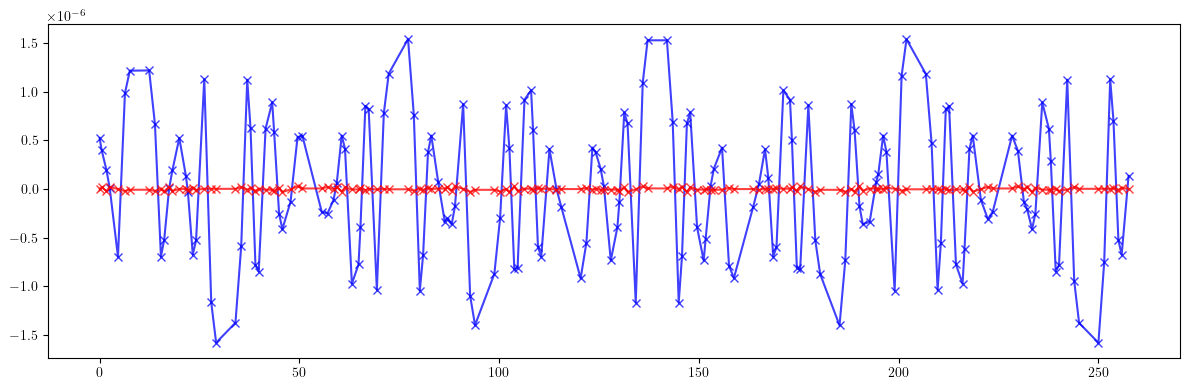

In [26]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

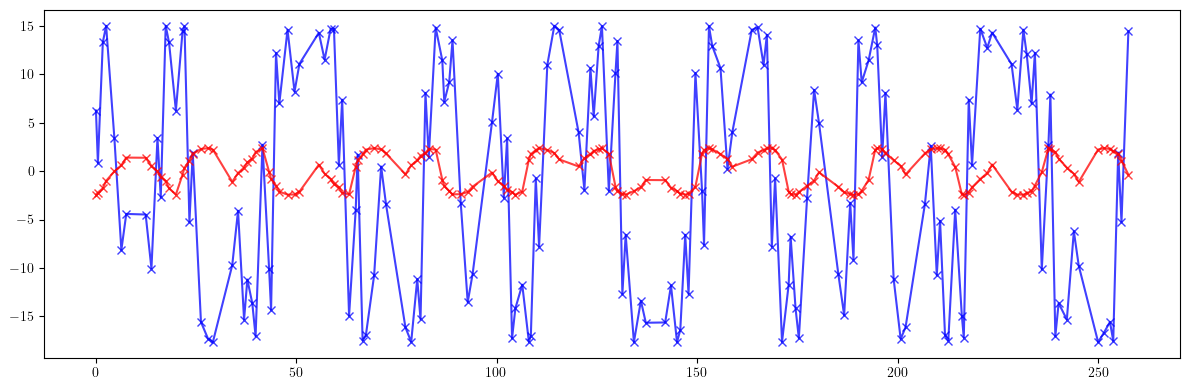

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)


In [27]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())

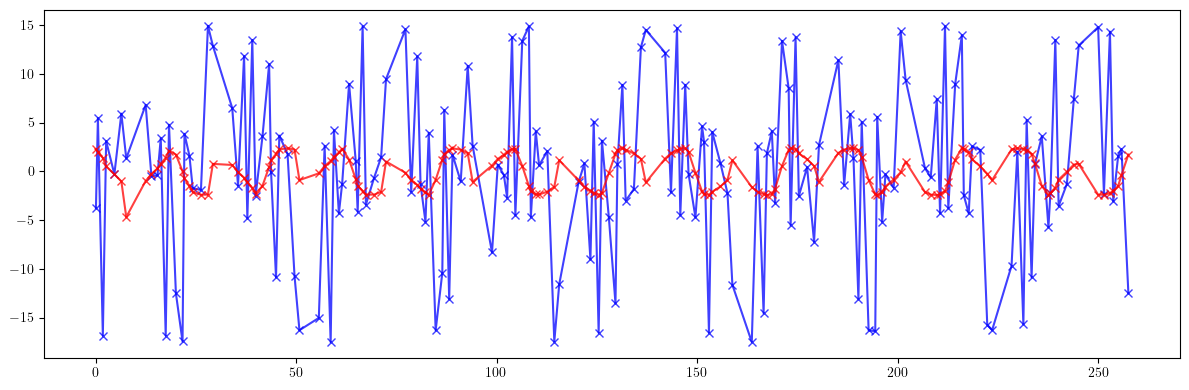

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)


In [28]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())

In [29]:
# Define parametric observable vector (emulate tune measurement)

def observable_orm(kn, ks):
    orm = ORM(error, orbit,  [kn, ks], ('kn', None, nkn, None), ('ks', None, nks, None), limit=1)
    return orm

def observable(knobs):
    kn, ks = torch.split(knobs, [6, 4])
    orm = observable_orm(kn, ks)
    return orm.flatten()

In [30]:
# Check the residual vector norm

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)

print(((observable(knobs) - target)**2).sum())

tensor(596.2449, dtype=torch.float64)


In [31]:
# Optimization loop (model free)

# Optimization loop (model free)

# Responce matrix (jacobian)

M = matrix.clone()

# Weighting covariance (sensitivity) matrix

epsilon = 1.0E-9
C = M @ M.T
C = C + epsilon*torch.eye(len(C), dtype=dtype)

# Cholesky decomposition

L = torch.linalg.cholesky(C) 

# Whiten response

M = torch.linalg.solve_triangular(L, M, upper=False)

# Additional weights
# Can be used to extra weight selected observables, e.g. tunes

weights = torch.ones(len(M), dtype=dtype)
weights = weights.sqrt()

# Whiten response with additional weights

M = M*weights.unsqueeze(1)

# Iterative correction

lr = 0.75

# Initial value

knobs = torch.tensor((6 + 4)*[0.0], dtype=dtype)

# Correction loop

for _ in range(8):
    value = observable(knobs)
    residual = target - value
    residual = torch.linalg.solve_triangular(L, residual.unsqueeze(-1), upper=False).squeeze(-1)
    residual = residual*weights
    delta = torch.linalg.lstsq(M, residual, driver="gels").solution
    knobs += lr*delta
    print(((value - target)**2).sum())
print()

tensor(596.2449, dtype=torch.float64)
tensor(64.1835, dtype=torch.float64)
tensor(22.2873, dtype=torch.float64)
tensor(12.3969, dtype=torch.float64)
tensor(10.1436, dtype=torch.float64)
tensor(9.7651, dtype=torch.float64)
tensor(9.7183, dtype=torch.float64)
tensor(9.7154, dtype=torch.float64)



In [32]:
# Check the residual vector norm

print(((observable(knobs) - target)**2).sum())

tensor(9.7161, dtype=torch.float64)


In [33]:
# Apply final corrections

kn, ks = torch.split(knobs, [6, 4])

result = error.clone()

result.flatten()

for name, knob in zip(nkn, kn):
    result[name].kn = (result[name].kn + knob).item()
    
for name, knob in zip(nks, ks):
    result[name].ks = (result[name].ks + knob).item()
    
result.splice()

In [34]:
# Compute tunes (fractional part)

nux_result, nuy_result = tune(result, [], matched=True, limit=1)

In [35]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_result, etapx_result, etaqy_result, etapy_result = dispersion(result, orbit, [], limit=1)

In [36]:
# Compute twiss parameters

ax_result, bx_result, ay_result, by_result = twiss(result, [], matched=True, advance=True, full=False).T

In [37]:
# Compute phase advances

mux_result, muy_result = advance(result, [], alignment=False, matched=True).T

In [38]:
# Compute coupling

c_result = coupling(result, [])

In [39]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_result).abs())
print((nuy - nuy_result).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(0.0009, dtype=torch.float64)
tensor(0.0003, dtype=torch.float64)



In [40]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_result)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(6.3535e-06, dtype=torch.float64)


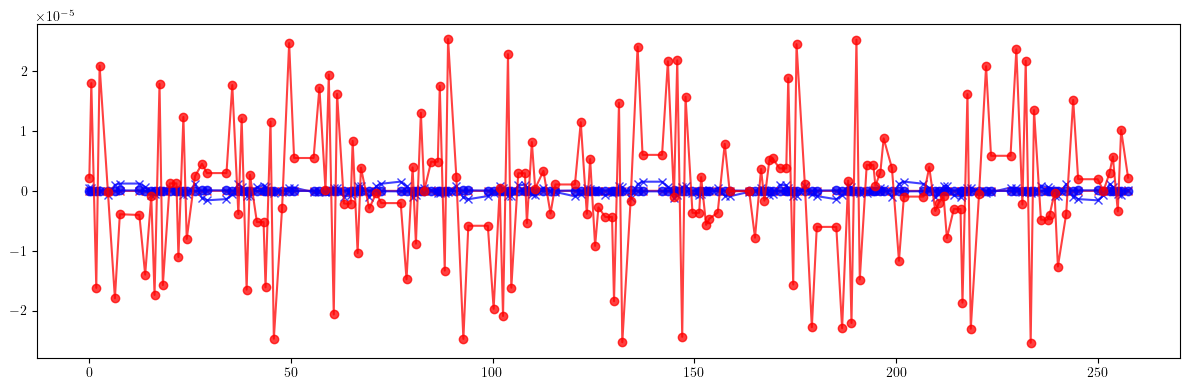

In [41]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_result).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_result).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

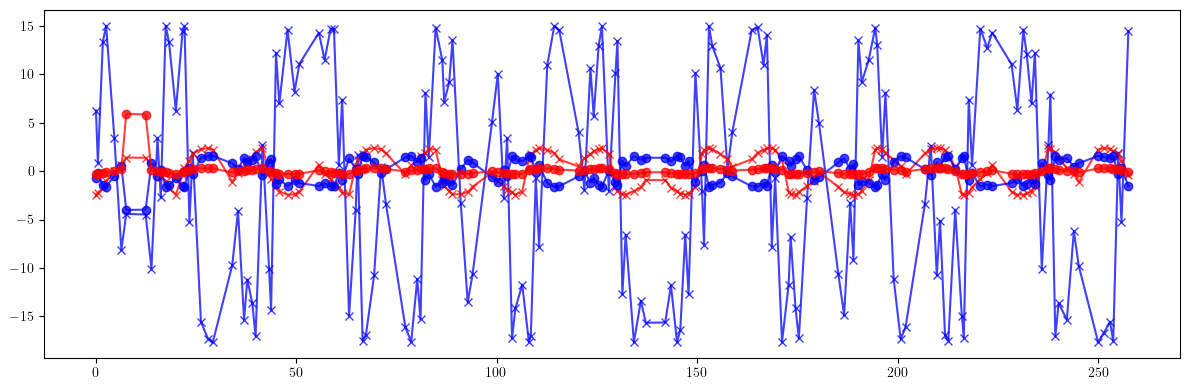

tensor(11.5994, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64)

tensor(1.2053, dtype=torch.float64)
tensor(0.6801, dtype=torch.float64)



In [42]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_result)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_result)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt())
print(100*(((by - by_id)/by)**2).mean().sqrt())
print()

print(100*(((bx - bx_result)/bx)**2).mean().sqrt())
print(100*(((by - by_result)/by)**2).mean().sqrt())
print()

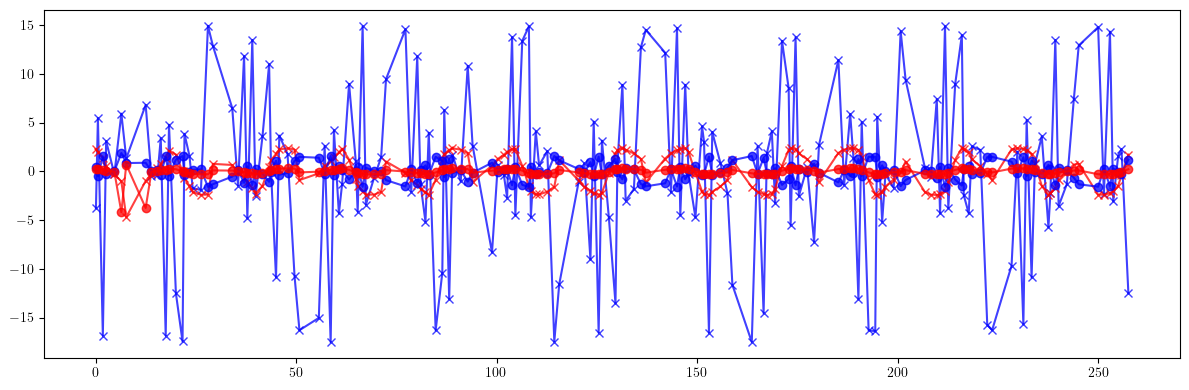

tensor(8.7941, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64)

tensor(0.8747, dtype=torch.float64)
tensor(0.4887, dtype=torch.float64)



In [43]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_result)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_result)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt())
print(100*(((muy - muy_id)/muy)**2).mean().sqrt())
print()

print(100*(((mux - mux_result)/mux)**2).mean().sqrt())
print(100*(((muy - muy_result)/muy)**2).mean().sqrt())
print()